# Kaggle House Price Prediction: Advanced Regression
### Project Goal:
Predict the final price of each home using 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

### Skills Demonstrated:
* Data Cleaning & Imputation
* Feature Encoding (One-Hot Encoding)
* Linear Regression Modeling
* Model Evaluation (RMSE & R-squared)

## 1. Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Styling
sns.set(style="whitegrid")

## 2. Load the Data

In [19]:
# Load dataset
train_df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')

# Drop the 'Id' column as it's not a predictor
train_df.drop('Id', axis=1, inplace=True)

print(f"Dataset Shape: {train_df.shape}")
print(train_df.info())

Dataset Shape: (1460, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-nu

In [20]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Simplified Data Cleaning

In [21]:
# Separate numerical and categorical columns
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

# Fill missing numerical values with median
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Fill missing categorical values with "None"
train_df[cat_cols] = train_df[cat_cols].fillna('None')

print("Missing values handled.")

Missing values handled.


## 4. Feature Encoding

In [22]:
# Create dummy variables for categorical data. Using One-Hot Encoding
train_final = pd.get_dummies(train_df)

print(f"Final Data Shape after Encoding: {train_final.shape}")

Final Data Shape after Encoding: (1460, 304)


## 5. Model Training

In [23]:
# Define Features (X) and Target (y)
X = train_final.drop('SalePrice', axis=1)
y = train_final['SalePrice']

# Split: 80% train, 20% cv (cross-validation)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 6. Model Evaluation

RMSE: $65,386.51
R-squared Score: 0.4426


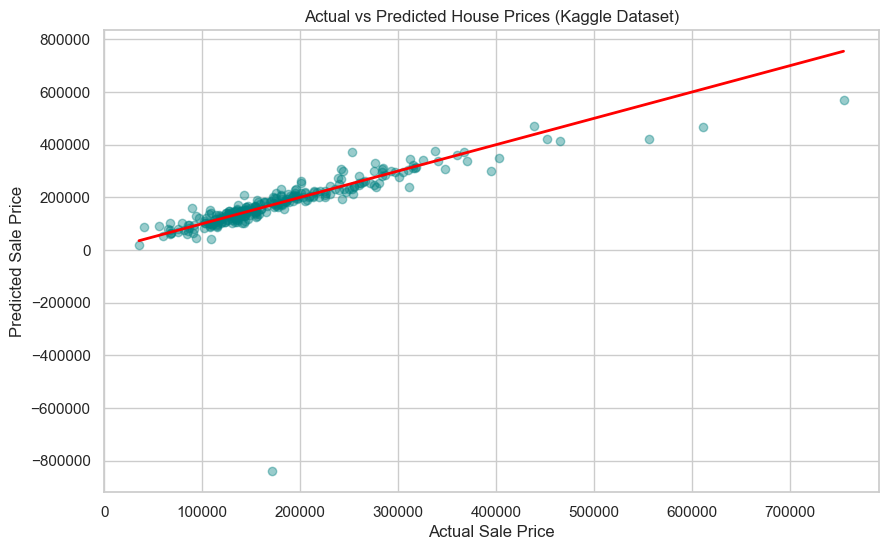

In [24]:
# Predictions
predictions = model.predict(X_cv)

# Metrics
rmse = np.sqrt(mean_squared_error(y_cv, predictions))
r2 = r2_score(y_cv, predictions)
print(f"RMSE: ${rmse:,.2f}")
print(f"R-squared Score: {r2:.4f}")

# Plotting Results
plt.figure(figsize=(10, 6))
plt.scatter(y_cv, predictions, alpha=0.4, color='teal')
plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], color='red', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted House Prices (Kaggle Dataset)')
plt.show()

## 7. Trying Random Forest

Random Forest RMSE: $29,534.81
Random Forest R-squared: 0.8863


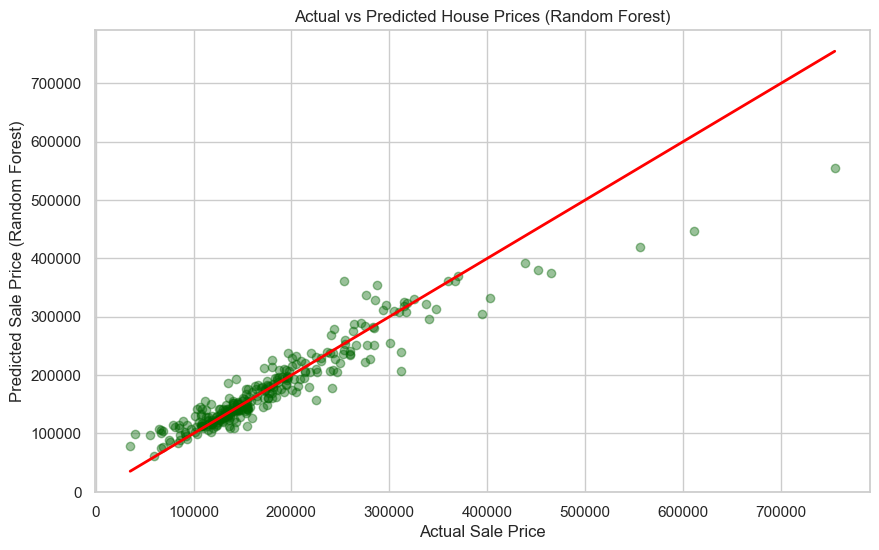

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest
# n_estimators=100 means we are using 100 decision trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
rf_pred = rf_model.predict(X_cv)

# Evaluation Metrics
rf_rmse = np.sqrt(mean_squared_error(y_cv, rf_pred))
rf_r2 = r2_score(y_cv, rf_pred)

print(f"Random Forest RMSE: ${rf_rmse:,.2f}")
print(f"Random Forest R-squared: {rf_r2:.4f}")

# Plotting the Results
plt.figure(figsize=(10, 6))
plt.scatter(y_cv, rf_pred, alpha=0.4, color='darkgreen')
plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], color='red', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price (Random Forest)')
plt.title('Actual vs Predicted House Prices (Random Forest)')
plt.show()

## 8. Feature Importance

In [28]:
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False).head(10))

        Feature  Importance
3   OverallQual    0.557666
15    GrLivArea    0.121527
11  TotalBsmtSF    0.035099
13     2ndFlrSF    0.033788
8    BsmtFinSF1    0.029108
12     1stFlrSF    0.025913
2       LotArea    0.016901
26   GarageArea    0.015540
5     YearBuilt    0.012439
25   GarageCars    0.012039


## 9. Correlation Heatmap

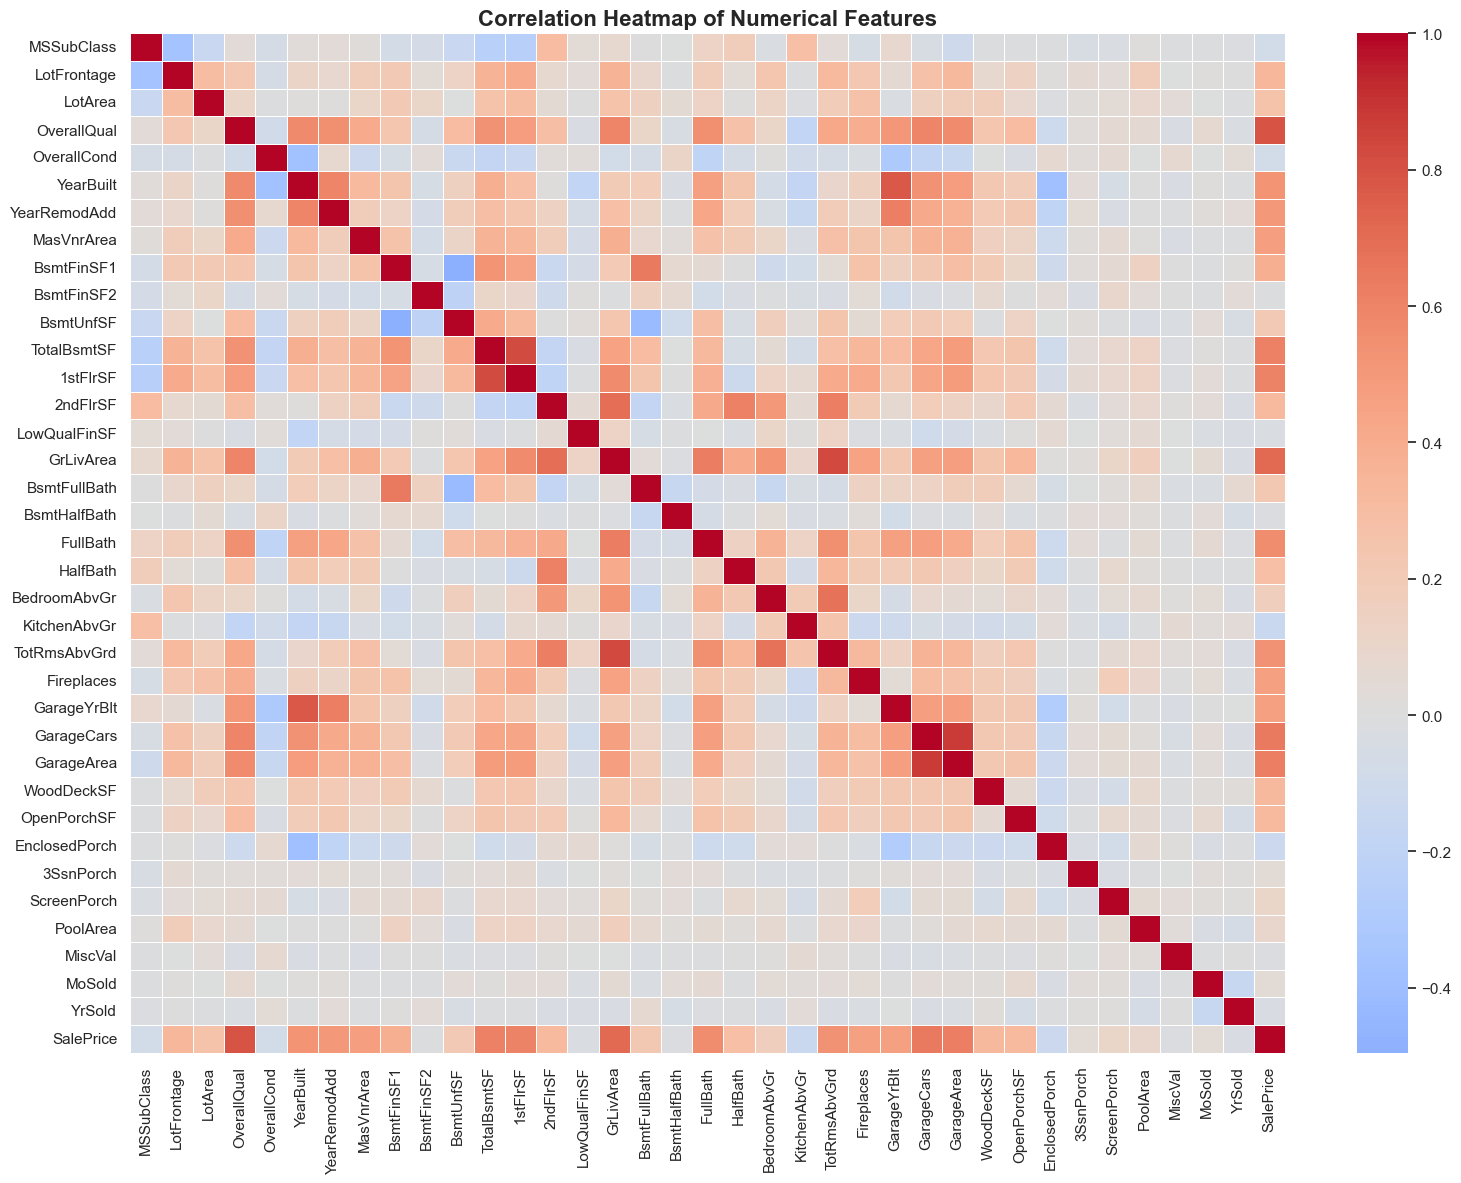


🎯 Top 15 Features Correlated with SalePrice:

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.466754
BsmtFinSF1      0.386420
LotFrontage     0.334771


In [29]:
# Correlation heatmap for numerical features
plt.figure(figsize=(16, 12))

# Calculate correlation matrix
corr_matrix = train_df[num_cols].corr()

# Create heatmap
sns.heatmap(corr_matrix, 
            annot=False, 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            fmt='.2f')

plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with SalePrice
print("\n🎯 Top 15 Features Correlated with SalePrice:\n")
sale_price_corr = corr_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)
print(sale_price_corr.head(15).to_string())

checking non-linearity  between 'Living Area' & 'Sale Price'

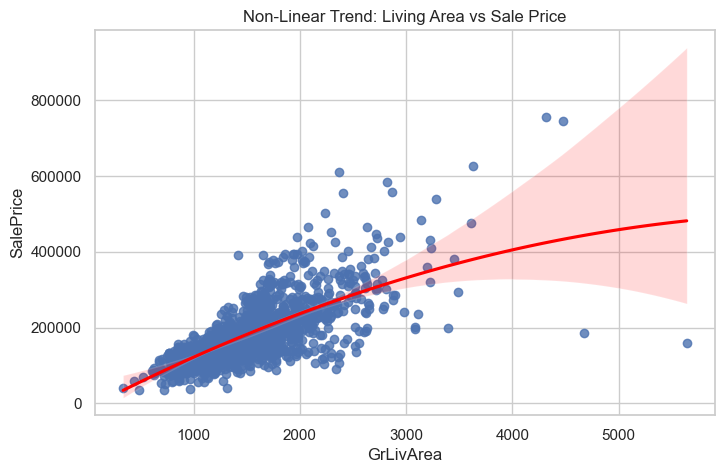

In [38]:
# Check for non-linearity in the top feature
plt.figure(figsize=(8, 5))
sns.regplot(data=train_df, x='GrLivArea', y='SalePrice', 
            order=2, line_kws={'color':'red'}) # 'order=2' fits a curve
plt.title('Non-Linear Trend: Living Area vs Sale Price')
plt.show()

## 10. Advanced Feature Engineering

In [39]:
# Create a copy to keep original data safe
X_advanced = X.copy()

# 1. Add Polynomial Features (degree=2) for non-linear trends
# We use the top numerical features from your importance list
X_advanced['GrLivArea_2'] = X_advanced['GrLivArea'] ** 2
X_advanced['TotalBsmtSF_2'] = X_advanced['TotalBsmtSF'] ** 2
X_advanced['YearBuilt_2'] = X_advanced['YearBuilt'] ** 2

# 2. Add Interaction Term
# This represents "High Quality * Large Space" as a single feature
X_advanced['Qual_x_LivArea'] = X_advanced['OverallQual'] * X_advanced['GrLivArea']

print(f"New feature count: {X_advanced.shape[1]}")
X_advanced[['GrLivArea_2', 'Qual_x_LivArea']].head()

New feature count: 307


,GrLivArea_2,Qual_x_LivArea
0,2924100,11970
1,1592644,7572
2,3189796,12502
3,2948089,12019
4,4831204,17584


## 11. Retraining RF Model

Advanced RF RMSE: $29,771.84
Advanced RF R-squared: 0.8844


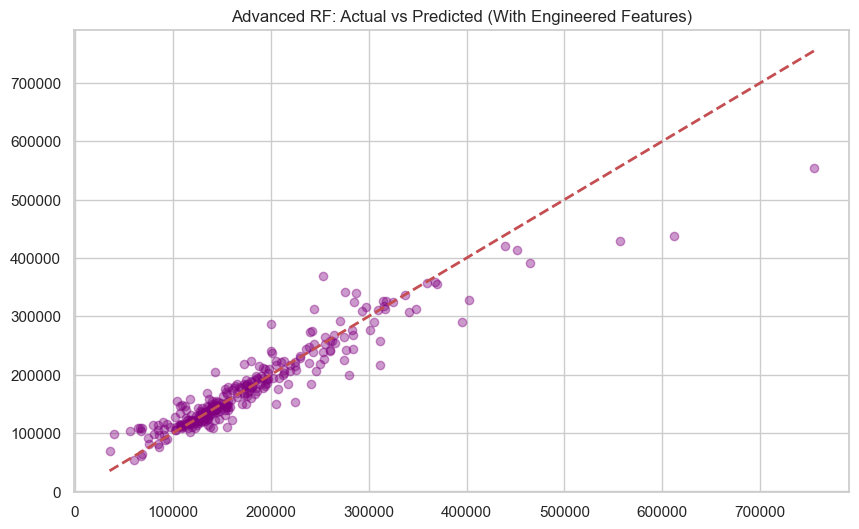

In [40]:
# Split the new advanced feature set
X_train_adv, X_test_adv, y_train, y_test = train_test_split(
    X_advanced, y, test_size=0.2, random_state=42
)

# Re-train Random Forest
rf_adv_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_adv_model.fit(X_train_adv, y_train)

# Predictions and Metrics
y_pred_adv = rf_adv_model.predict(X_test_adv)
adv_r2 = rf_adv_model.score(X_test_adv, y_test)
adv_rmse = np.sqrt(mean_squared_error(y_test, y_pred_adv))

print(f"Advanced RF RMSE: ${adv_rmse:,.2f}")
print(f"Advanced RF R-squared: {adv_r2:.4f}")

# Plotting to see the new clustering
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_adv, alpha=0.4, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Advanced RF: Actual vs Predicted (With Engineered Features)')
plt.show()